In [2]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import gc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import mlflow
import mlflow.tensorflow

In [13]:
# Enable autologging
mlflow.tensorflow.autolog()
mlflow.set_tracking_uri(uri="file:///C:/Users/jcwin/OneDrive - University of Southampton/_Southampton/2024-25/Star-Classifier/mlflow")
mlflow.set_experiment("star-classifier")



class BalancedDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size=32, limit_per_label=1600):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.limit_per_label = limit_per_label
        self.classes = np.unique(y)
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X_batch = self.X[indices]
        y_batch = self.y[indices]
        return X_batch, y_batch

    def on_epoch_end(self):
        self.indices = []
        for cls in self.classes:
            cls_indices = np.where(self.y == cls)[0]
            if len(cls_indices) > self.limit_per_label:
                cls_indices = np.random.choice(cls_indices, self.limit_per_label, replace=False)
            self.indices.extend(cls_indices)
        np.random.shuffle(self.indices)

# Custom BalancedDataGenerator class for validation (400 per class)
class BalancedValidationGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size=32, limit_per_label=400):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.limit_per_label = limit_per_label
        self.classes = np.unique(y)
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X_batch = self.X[indices]
        y_batch = self.y[indices]
        return X_batch, y_batch

    def on_epoch_end(self):
        self.indices = []
        for cls in self.classes:
            cls_indices = np.where(self.y == cls)[0]
            if len(cls_indices) > self.limit_per_label:
                cls_indices = np.random.choice(cls_indices, self.limit_per_label, replace=False)
            self.indices.extend(cls_indices)
        np.random.shuffle(self.indices)

# Create the Conv1D model
def create_convnet(input_shape, num_classes, 
                   num_filters=[128, 128, 128, 128, 128, 128, 128, 128], 
                   kernel_size=9,
                   dense_units=[256, 256, 256, 128, 128, 128, 64, 64, 64],
                   dropout_rate=0.2,
                   padding='same'):
    model = tf.keras.models.Sequential()
    
    # First convolutional layer
    model.add(tf.keras.layers.Conv1D(filters=num_filters[0], kernel_size=kernel_size, 
                                     activation='relu', input_shape=input_shape, padding=padding))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    # Additional convolutional layers
    for filters in num_filters[1:]:
        model.add(tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, 
                                         activation='relu', padding=padding))
        model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    
    # Flatten the output and add dense layers
    model.add(tf.keras.layers.Flatten())

    for units in dense_units:
        model.add(tf.keras.layers.Dense(units=units, activation='relu'))
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    
    # Output layer
    model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

    # Optimizer and loss function
    optimizer_ = tf.keras.optimizers.AdamW(learning_rate=1e-4) 

    # Compile the model
    model.compile(optimizer=optimizer_, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Function to train the model
def train_convnet(model, train_dataset, val_dataset, limit_per_label=1600, epochs=1, batch_size=32, patience=5):
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Start an MLflow run
    with mlflow.start_run():
        # Fit the model
        history = model.fit(train_dataset,
                            validation_data=val_dataset,
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[early_stopping])
    
    return history

# Function to train the model multiple times
def train_convnet_many_times(model, train_dataset, val_dataset, epochs_per_run=1, batch_size=512, num_runs=10, limit_per_label=1600):
    histories = []
    for i in range(num_runs):
        print(f"Training run {i+1}/{num_runs}...")
        history = train_convnet(model, train_dataset, val_dataset, limit_per_label=limit_per_label, epochs=epochs_per_run, batch_size=batch_size)
        histories.append(history)
    
    return histories

# Function to print confusion matrix and classification report
def print_confusion_matrix(convnet_model, val_spectra, val_labels):   
    val_predictions = convnet_model.predict(val_spectra)
    predicted_labels = np.argmax(val_predictions, axis=1)
    true_labels = np.array(val_labels)

    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    print("Confusion Matrix:")
    print(conf_matrix)

    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels))

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Star', 'Binary Star','Galaxy', 'AGN'], yticklabels=['Star', 'Binary Star','Galaxy', 'AGN'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [10]:
# Define input shape and number of classes
input_shape = (3748, 1)
num_classes = len(np.unique(y_val))
batchsize = 512


# Load and preprocess data
X = pd.read_pickle("Pickles/fusionv0/train.pkl")
y = X["label"]
label_mapping = {'star': 0, 'binary_star': 1, 'galaxy': 2, 'agn': 3}
y = y.map(label_mapping) if isinstance(y, pd.Series) else np.vectorize(label_mapping.get)(y)

X = X.drop(["parallax", "ra", "dec", "ra_error", "dec_error", "parallax_error", "pmra", "pmdec", "pmra_error", "pmdec_error", 
            "phot_g_mean_flux", "flagnopllx", "phot_g_mean_flux_error", "phot_bp_mean_flux", "phot_rp_mean_flux", 
            "phot_bp_mean_flux_error", "phot_rp_mean_flux_error", "label"], axis=1)

# Read test data
X_test = pd.read_pickle("Pickles/fusionv0/test.pkl")
y_test = X_test["label"]
label_mapping = {'star': 0, 'binary_star': 1, 'galaxy': 2, 'agn': 3}
y_test = y_test.map(label_mapping) if isinstance(y_test, pd.Series) else np.vectorize(label_mapping.get)(y_test)

X_test = X_test.drop(["parallax", "ra", "dec", "ra_error", "dec_error", "parallax_error", "pmra", "pmdec", "pmra_error", "pmdec_error",
                        "phot_g_mean_flux", "flagnopllx", "phot_g_mean_flux_error", "phot_bp_mean_flux", "phot_rp_mean_flux",
                        "phot_bp_mean_flux_error", "phot_rp_mean_flux_error", "label"], axis=1)



# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = np.expand_dims(X_train.to_numpy(), axis=-1)
y_train = y_train.to_numpy()
X_val = np.expand_dims(X_val.to_numpy(), axis=-1)
y_val = y_val.to_numpy()

# Clear memory
del X, y
gc.collect()

# Create data generators
train_generator = BalancedDataGenerator(X_train, y_train, batch_size=batchsize, limit_per_label=1600)
val_generator = BalancedValidationGenerator(X_val, y_val, batch_size=batchsize, limit_per_label=400)

In [11]:
# Create and train the model
filters=[64, 128, 128, 256, 256, 512, 512, 512, 1024, 1024]
dense=[512, 256, 64]
model = create_convnet(input_shape, num_classes, num_filters=filters, kernel_size=(9,), dense_units=dense)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_37 (Conv1D)          (None, 3748, 64)          640       
                                                                 
 max_pooling1d_37 (MaxPooli  (None, 1874, 64)          0         
 ng1D)                                                           
                                                                 
 conv1d_38 (Conv1D)          (None, 1874, 128)         73856     
                                                                 
 max_pooling1d_38 (MaxPooli  (None, 937, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_49 (Dropout)        (None, 937, 128)          0         
                                                                 
 conv1d_39 (Conv1D)          (None, 937, 128)         

In [ ]:
histories = train_convnet_many_times(model, train_generator, val_generator, epochs_per_run=1, num_runs=10)

2024/10/18 13:40:12 WARNING mlflow.tensorflow: Unrecognized dataset type <class '__main__.BalancedDataGenerator'>. Dataset logging skipped.
2024/10/18 13:40:12 WARNING mlflow.tensorflow: Unrecognized dataset type <class '__main__.BalancedValidationGenerator'>. Dataset logging skipped.


Training run 1/10...
 2/11 [====>.........................] - ETA: 3:48 - loss: 1.3864 - accuracy: 0.2275

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


# Pytorch version

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import mlflow.pytorch
import gc
import psutil
import GPUtil

# Enable MLflow autologging for PyTorch
mlflow.pytorch.autolog()
mlflow.set_tracking_uri(uri="file:///C:/Users/jcwin/OneDrive - University of Southampton/_Southampton/2024-25/Star-Classifier/mlflow")
mlflow.set_experiment("star-classifier")

# Custom Dataset for handling balanced data
class BalancedDataset(Dataset):
    def __init__(self, X, y, limit_per_label=1600):
        self.X = X
        self.y = y
        self.limit_per_label = limit_per_label
        self.classes = np.unique(y)
        self.indices = self.balance_classes()

    def balance_classes(self):
        indices = []
        for cls in self.classes:
            cls_indices = np.where(self.y == cls)[0]
            if len(cls_indices) > self.limit_per_label:
                cls_indices = np.random.choice(cls_indices, self.limit_per_label, replace=False)
            indices.extend(cls_indices)
        np.random.shuffle(indices)
        return indices

    def re_sample(self):
        self.indices = self.balance_classes()

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        return self.X[index], self.y[index]
# Custom Dataset for validation with limit per class
class BalancedValidationDataset(Dataset):
    def __init__(self, X, y, limit_per_label=400):
        self.X = X
        self.y = y
        self.limit_per_label = limit_per_label
        self.classes = np.unique(y)
        self.indices = self.balance_classes()

    def balance_classes(self):
        indices = []
        for cls in self.classes:
            cls_indices = np.where(self.y == cls)[0]
            if len(cls_indices) > self.limit_per_label:
                cls_indices = np.random.choice(cls_indices, self.limit_per_label, replace=False)
            indices.extend(cls_indices)
        np.random.shuffle(indices)
        return indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        return self.X[index], self.y[index]

# Define the Conv1D PyTorch model
class ConvNet(nn.Module):
    def __init__(self, input_shape, num_classes, 
                 num_filters=[128, 128, 128, 128, 128, 128, 128, 128], 
                 kernel_size=9,
                 dense_units=[256, 256, 256, 128, 128, 128, 64, 64, 64],
                 dropout_rate=0.2, padding='same'):
        super(ConvNet, self).__init__()
        
        self.conv_layers = nn.ModuleList()
        self.pool_layers = nn.ModuleList()
        in_channels = 1  # Since it's a 1D input
        
        # Add convolutional layers
        for filters in num_filters:
            conv_layer = nn.Conv1d(in_channels=in_channels, out_channels=filters, kernel_size=kernel_size, padding=kernel_size//2)
            self.conv_layers.append(conv_layer)
            self.pool_layers.append(nn.MaxPool1d(kernel_size=2))
            in_channels = filters
        
        self.dropout = nn.Dropout(dropout_rate)
        self.flatten = nn.Flatten()
        
        # Compute the flattened output size (based on input shape and pooling)
        # Assumption: input_shape[0] is the sequence length
        final_seq_len = input_shape[0] // (2 ** len(num_filters))  # After all pooling layers
        
        # Add dense layers
        dense_input_units = num_filters[-1] * final_seq_len
        self.dense_layers = nn.ModuleList()
        for units in dense_units:
            self.dense_layers.append(nn.Linear(dense_input_units, units))
            dense_input_units = units
        
        # Output layer
        self.output_layer = nn.Linear(dense_input_units, num_classes)
    
    def forward(self, x):
        for conv_layer, pool_layer in zip(self.conv_layers, self.pool_layers):
            x = pool_layer(torch.relu(conv_layer(x)))
            x = self.dropout(x)
        x = self.flatten(x)
        for dense_layer in self.dense_layers:
            x = torch.relu(dense_layer(x))
            x = self.dropout(x)
        x = self.output_layer(x)
        return torch.softmax(x, dim=1)

def log_system_metrics(epoch):
    cpu_usage = psutil.cpu_percent()
    memory_info = psutil.virtual_memory()
    gpus = GPUtil.getGPUs()
    gpu_usage = gpus.load * 100 if gpus else None

    mlflow.log_metric("cpu_usage", cpu_usage, step=epoch)
    mlflow.log_metric("memory_usage", memory_info.percent, step=epoch)
    if gpu_usage is not None:
        mlflow.log_metric("gpu_usage", gpu_usage, step=epoch)
def log_system_metrics(epoch):
    cpu_usage = psutil.cpu_percent()
    memory_info = psutil.virtual_memory()
    gpus = GPUtil.getGPUs()
    
    if gpus:
        for i, gpu in enumerate(gpus):
            mlflow.log_metric(f"gpu_{i}_usage", gpu.load * 100, step=epoch)
            mlflow.log_metric(f"gpu_{i}_memory_used", gpu.memoryUsed, step=epoch)
            mlflow.log_metric(f"gpu_{i}_memory_total", gpu.memoryTotal, step=epoch)
    
    mlflow.log_metric("cpu_usage", cpu_usage, step=epoch)
    mlflow.log_metric("memory_usage", memory_info.percent, step=epoch)

# Updated train_model function with system metrics logging
def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4, patience=5, device='cuda'):
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    early_stopping_counter = 0
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Re-sample the training dataset at the start of each epoch
        train_loader.dataset.re_sample()
        
        model.train()
        train_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_accuracy = (outputs.argmax(dim=1) == y_batch).float().mean()
            train_loss += loss.item() * X_batch.size(0)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                val_accuracy = (outputs.argmax(dim=1) == y_val).float().mean()
                loss = criterion(outputs, y_val)
                val_loss += loss.item() * X_val.size(0)
        
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)

        # Log metrics to MLflow
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_accuracy", val_accuracy.item(), step=epoch)
        mlflow.log_metric("train_accuracy", train_accuracy.item(), step=epoch)
        
        # Log system metrics
        log_system_metrics(epoch)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("Early stopping triggered.")
                break
    
    return model
# Confusion matrix and classification report
def print_confusion_matrix(model, val_loader, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            preds = model(X_batch).cpu().numpy()
            all_preds.extend(np.argmax(preds, axis=1))
            all_labels.extend(y_batch.numpy())

    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(conf_matrix)

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=['Star', 'Binary Star', 'Galaxy', 'AGN'], 
                yticklabels=['Star', 'Binary Star', 'Galaxy', 'AGN'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Main script to load data and train the model
if __name__ == "__main__":
    # Load and preprocess data
    X = pd.read_pickle("Pickles/fusionv0/train.pkl")
    y = X["label"]
    label_mapping = {'star': 0, 'binary_star': 1, 'galaxy': 2, 'agn': 3}
    y = y.map(label_mapping).values
    
    X = X.drop(["parallax", "ra", "dec", "ra_error", "dec_error", "parallax_error", "pmra", "pmdec", "pmra_error", "pmdec_error", 
                "phot_g_mean_flux", "flagnopllx", "phot_g_mean_flux_error", "phot_bp_mean_flux", "phot_rp_mean_flux", 
                "phot_bp_mean_flux_error", "phot_rp_mean_flux_error", "label"], axis=1).values
    
    # Read test data
    X_test = pd.read_pickle("Pickles/fusionv0/test.pkl")
    y_test = X_test["label"].map(label_mapping).values
    X_test = X_test.drop(["parallax", "ra", "dec", "ra_error", "dec_error", "parallax_error", "pmra", "pmdec", "pmra_error", "pmdec_error", 
                "phot_g_mean_flux", "flagnopllx", "phot_g_mean_flux_error", "phot_bp_mean_flux", "phot_rp_mean_flux", 
                "phot_bp_mean_flux_error", "phot_rp_mean_flux_error", "label"], axis=1).values
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Clear memory
    del X, y
    gc.collect()

    # Convert to torch tensors and create datasets
    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
    X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_val = torch.tensor(y_val, dtype=torch.long)

    train_dataset = BalancedDataset(X_train, y_train)
    val_dataset = BalancedValidationDataset(X_val, y_val)
    
    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)


2024/10/18 14:46:38 WARNING mlflow.utils.autologging_utils: MLflow pytorch autologging is known to be compatible with 1.9.0 <= torch <= 2.4.1, but the installed version is 2.4.1+cu124. If you encounter errors during autologging, try upgrading / downgrading torch to a compatible version, or try upgrading MLflow.


In [37]:
# Initialize model, train, and evaluate
filters=[128, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512]
dense=[512, 256, 64]
model = ConvNet(input_shape=(3748,), num_classes=4, num_filters=filters, kernel_size=9, dense_units=dense, dropout_rate=0.2)



# model summary
print(model)

# Print number of parameters
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


ConvNet(
  (conv_layers): ModuleList(
    (0): Conv1d(1, 128, kernel_size=(9,), stride=(1,), padding=(4,))
    (1-2): 2 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(4,))
    (3): Conv1d(128, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (4-5): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (6): Conv1d(256, 512, kernel_size=(9,), stride=(1,), padding=(4,))
    (7-10): 4 x Conv1d(512, 512, kernel_size=(9,), stride=(1,), padding=(4,))
  )
  (pool_layers): ModuleList(
    (0-10): 11 x MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense_layers): ModuleList(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=4, bias=True)
)
Number of pa

In [ ]:
num_epochs = 200
lr = 1e-4
patience = num_epochs
batch_size = 512
dropout_rate = 0.2
kernel_size = 9

# Start an MLflow run
with mlflow.start_run(log_system_metrics=True):
    # Log parameters
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("lr", lr)
    mlflow.log_param("patience", patience)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("num_filters", filters)
    mlflow.log_param("dense_units", dense)
    mlflow.log_param("dropout_rate", dropout_rate)
    mlflow.log_param("kernel_size", kernel_size)

    # Train the model
    trained_model = train_model(model, train_loader, val_loader, num_epochs=num_epochs, lr=lr, patience=patience)

    # Evaluate the model
    print_confusion_matrix(trained_model, val_loader)

    # Save the model
    mlflow.pytorch.log_model(trained_model, "model")

2024/10/18 14:46:57 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch 1/200, Train Loss: 1.2131, Val Loss: 1.1406, Val Accuracy: 0.6067
Epoch 2/200, Train Loss: 1.1564, Val Loss: 1.1041, Val Accuracy: 0.6399
Epoch 3/200, Train Loss: 1.1280, Val Loss: 1.0837, Val Accuracy: 0.6595
Epoch 4/200, Train Loss: 1.1160, Val Loss: 1.0879, Val Accuracy: 0.6517
Epoch 5/200, Train Loss: 1.0938, Val Loss: 1.0737, Val Accuracy: 0.6791
Epoch 6/200, Train Loss: 1.0924, Val Loss: 1.0640, Val Accuracy: 0.6712
Epoch 7/200, Train Loss: 1.0914, Val Loss: 1.0495, Val Accuracy: 0.7065
Epoch 8/200, Train Loss: 1.0746, Val Loss: 1.0505, Val Accuracy: 0.6947
Epoch 9/200, Train Loss: 1.0698, Val Loss: 1.0376, Val Accuracy: 0.7143
Epoch 10/200, Train Loss: 1.0693, Val Loss: 1.0349, Val Accuracy: 0.7162
Epoch 11/200, Train Loss: 1.0638, Val Loss: 1.0451, Val Accuracy: 0.7025
Epoch 12/200, Train Loss: 1.0594, Val Loss: 1.0346, Val Accuracy: 0.7182
Epoch 13/200, Train Loss: 1.0454, Val Loss: 1.0282, Val Accuracy: 0.7319
Epoch 14/200, Train Loss: 1.0397, Val Loss: 1.0184, Val Accu

In [22]:
mlflow.get_experiment_by_name("star-classifier")

<Experiment: artifact_location=('file:///C:/Users/jcwin/OneDrive - University of '
 'Southampton/_Southampton/2024-25/Star-Classifier/mlflow/388374043760357004'), creation_time=1729184230130, experiment_id='388374043760357004', last_update_time=1729184230130, lifecycle_stage='active', name='star-classifier', tags={}>

In [23]:
with mlflow.start_run():
    mlflow.log_param("example_param", "test_value")
    mlflow.log_metric("example_metric", 0.5)


Confusion Matrix:
[[246 131   7  16]
 [128 249   5  18]
 [  3   3 355  15]
 [  9   6  59 326]]

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.61      0.63       400
           1       0.64      0.62      0.63       400
           2       0.83      0.94      0.89       376
           3       0.87      0.81      0.84       400

    accuracy                           0.75      1576
   macro avg       0.75      0.75      0.75      1576
weighted avg       0.74      0.75      0.74      1576



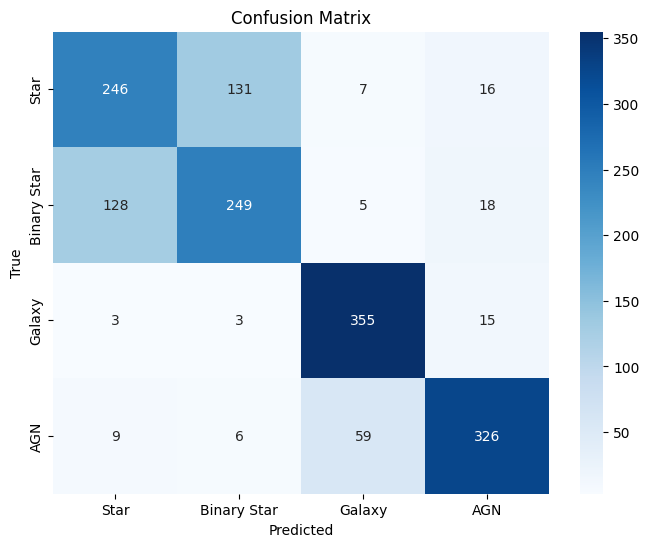

In [21]:
# Evaluate with confusion matrix and classification report
test_loader = DataLoader(BalancedValidationDataset(torch.tensor(X_test, dtype=torch.float32).unsqueeze(1),
                                                    torch.tensor(y_test, dtype=torch.long)),
                         batch_size=512, shuffle=False)
print_confusion_matrix(trained_model, test_loader)

In [10]:
# check if gpu is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda
